In [75]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import os
import cv2
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
from keras.layers import Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras import layers, models
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2


In [76]:
from google. colab import drive
drive. mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
train_path='/content/drive/MyDrive/Deep Learning dataset/Train'
test_path='/content/drive/MyDrive/Deep Learning dataset/Test'

In [78]:
batch_size = 32
img_width=224
img_height=224
img_size=128
epochs=50
NUM_CLASSES=2


In [80]:

data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/Deep Learning dataset/Train',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    #class_mode = 'binary',
    seed = 42,
    subset='training')

validation_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/Deep Learning dataset/Test',
    target_size =(img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
   # class_mode = 'binary',
    seed = 42,
    subset='validation')

Found 84 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define data directories
train_directory = '/content/drive/MyDrive/Deep Learning dataset/Train'
validation_directory = '/content/drive/MyDrive/Deep Learning dataset/Test'

# Create data generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 104 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [81]:
import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

(64, 224, 224, 3) (64, 2)


In [82]:
X_test, y_test = next(validation_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

(84, 224, 224, 3) (84, 2)


In [83]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(1):  # Apply augmentation twice
            for batch in datagen.flow(img, batch_size=1):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

In [84]:
# Apply augmentation twice to X_train, X_test, and X_val
X_train_augmented = augment_dataset(X_train)
X_test_augmented = augment_dataset(X_test)
#X_val_augmented = augment_dataset(X_val)
y_train_augmented = np.repeat(y_train, 1, axis=0)  # Adjust based on augmentation factor
y_test_augmented = np.repeat(y_test, 1, axis=0)  # Adjust based on augmentation factor

In [85]:
from sklearn.utils import shuffle

# Combine original data with augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

X_test_combined = np.concatenate((X_test, X_test_augmented))
y_test_combined = np.concatenate((y_test, y_test_augmented))


# Shuffle the combined data
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)
X_test_combined, y_test_combined = shuffle(X_test_combined, y_test_combined, random_state=42)

In [86]:
#from keras.applications import vgg19


img_rows, img_cols = 224, 224

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))


for layer in mobilenetv2.layers:
    layer.trainable = False
# Let's print our layers
for (i,layer) in enumerate(mobilenetv2.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

9406464/9406464 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 Conv2D False
10 BatchNormalization False
11 ReLU False
12 ZeroPadding2D False
13 DepthwiseConv2D False
14 BatchNormalization False
15 ReLU False
16 Conv2D False
17 BatchNormalization False
18 Conv2D False
19 BatchNormalization False
20 ReLU False
21 DepthwiseConv2D False
22 BatchNormalization False
23 ReLU False
24 Conv2D False
25 BatchNormalization False
26 Add False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 ZeroPadding2D False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 Conv2D False
37 BatchNormalization False
38 ReLU False
39 DepthwiseConv2D False
40 BatchNormalization False
41 ReLU False
42 Conv2D False
43 BatchNormalization False
44 Add False
45 Conv2D 

In [87]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D


from keras.models import Model


num_classes = 2

FC_Head = lw(mobilenetv2, num_classes)


model = Model(inputs = mobilenetv2.input, outputs = FC_Head)

In [89]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [90]:
from keras.models import Model
import tensorflow as tf
from keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.F1Score(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),]

In [91]:
# Compile Model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1), loss = 'binary_crossentropy',metrics = metrics)

In [92]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=3,
         restore_best_weights=True,
    )
]
history = model.fit(X_train_combined, y_train_combined, epochs=50,batch_size=32,validation_split=0.2,callbacks=callbacks)

Epoch 1/50
5/5 [==============================] - 16s 2s/step - loss: 136183.6094 - accuracy: 0.5149 - auc_2: 0.5088 - recall_2: 0.4179 - precision_2: 0.5138 - f1_score: 0.5275 - specificity_at_sensitivity_2: 0.5448 - sensitivity_at_specificity_2: 0.5597 - false_negatives_2: 78.0000 - false_positives_2: 53.0000 - true_negatives_2: 81.0000 - true_positives_2: 56.0000 - val_loss: 6448.6421 - val_accuracy: 0.6176 - val_auc_2: 0.7794 - val_recall_2: 0.9412 - val_precision_2: 0.7111 - val_f1_score: 0.8402 - val_specificity_at_sensitivity_2: 0.6176 - val_sensitivity_at_specificity_2: 0.9412 - val_false_negatives_2: 2.0000 - val_false_positives_2: 13.0000 - val_true_negatives_2: 21.0000 - val_true_positives_2: 32.0000
Epoch 2/50
5/5 [==============================] - 11s 2s/step - loss: 2785.7939 - accuracy: 0.8955 - auc_2: 0.9291 - recall_2: 0.9627 - precision_2: 0.9021 - f1_score: 0.9318 - specificity_at_sensitivity_2: 0.8955 - sensitivity_at_specificity_2: 0.9627 - false_negatives_2: 5.000

In [93]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 242ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - auc_2: 1.0000 - recall_2: 1.0000 - precision_2: 1.0000 - f1_score: 1.0000 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - false_negatives_2: 0.0000e+00 - false_positives_2: 0.0000e+00 - true_negatives_2: 4.0000 - true_positives_2: 4.0000


[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 array([1., 1.], dtype=float32),
 1.0,
 1.0,
 0.0,
 0.0,
 4.0,
 4.0]

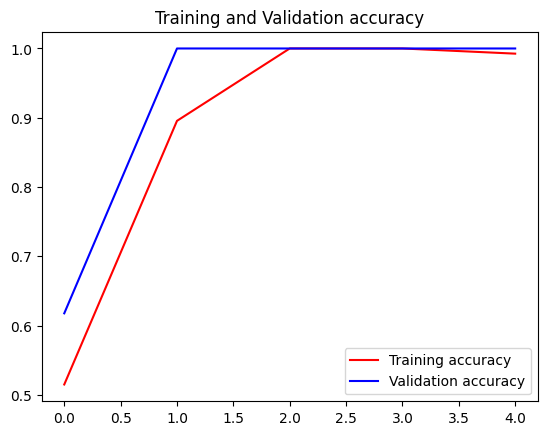

<Figure size 640x480 with 0 Axes>

In [94]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

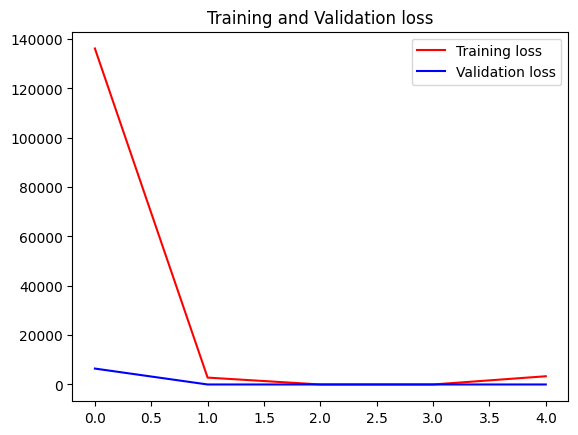

<Figure size 640x480 with 0 Axes>

In [95]:
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()